# Batch Normalization
:label:`sec_batch_norm`

Training deep neural networks is difficult.
Getting them to converge in a reasonable amount of time can be tricky.
In this section, we describe *batch normalization*, a popular and effective technique
that consistently accelerates the convergence of deep networks :cite:`Ioffe.Szegedy.2015`.
Together with residual blocks---covered later in :numref:`sec_resnet`---batch normalization
has made it possible for practitioners to routinely train networks with over 100 layers.
A secondary (serendipitous) benefit of batch normalization lies in its inherent regularization.

# 批量归一化
:label:`sec_batch_norm`

训练深度神经网络十分困难。
让它们在合理范围内迅速收敛更加棘手。
本节我们将介绍批量归一化（batch normalization）技术：一种流行且有效的技术
可持续加速深层网络的收敛速度 :cite:`Ioffe.Szegedy.2015`。
结合后续将介绍的残差块（residual blocks）——批量归一化
使从业者能够常规性地训练超过100层的网络。
批量归一化的一个意外之益在于其固有的正则化特性。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Training Deep Networks

When working with data, we often preprocess before training.
Choices regarding data preprocessing often make an enormous difference in the final results.
Recall our application of MLPs to predicting house prices (:numref:`sec_kaggle_house`).
Our first step when working with real data
was to standardize our input features to have
zero mean $\boldsymbol{\mu} = 0$ and unit variance $\boldsymbol{\Sigma} = \boldsymbol{1}$ across multiple observations :cite:`friedman1987exploratory`, frequently rescaling the latter so  that the diagonal is unity, i.e., $\Sigma_{ii} = 1$.
Yet another strategy is to rescale vectors to unit length, possibly zero mean *per observation*.
This can work well, e.g., for spatial sensor data. These preprocessing techniques and many others, are
beneficial for keeping the estimation problem well controlled. 
For a review of feature selection and extraction see the article of :citet:`guyon2008feature`, for example.
Standardizing vectors also has the nice side-effect of constraining the function complexity of functions that act upon it. For instance, the celebrated radius-margin bound :cite:`Vapnik95` in support vector machines and the Perceptron Convergence Theorem :cite:`Novikoff62` rely on inputs of bounded norm. 

Intuitively, this standardization plays nicely with our optimizers
since it puts the parameters *a priori* on a similar scale.
As such, it is only natural to ask whether a corresponding normalization step *inside* a deep network
might not be beneficial. While this is not quite the reasoning that led to the invention of batch normalization :cite:`Ioffe.Szegedy.2015`, it is a useful way of understanding it and its cousin, layer normalization :cite:`Ba.Kiros.Hinton.2016`, within a unified framework.

Second, for a typical MLP or CNN, as we train,
the variables 
in intermediate layers (e.g., affine transformation outputs in MLP)
may take values with widely varying magnitudes:
whether along the layers from input to output, across units in the same layer,
and over time due to our updates to the model parameters.
The inventors of batch normalization postulated informally
that this drift in the distribution of such variables could hamper the convergence of the network.
Intuitively, we might conjecture that if one
layer has variable activations that are 100 times that of another layer,
this might necessitate compensatory adjustments in the learning rates. Adaptive solvers
such as AdaGrad :cite:`Duchi.Hazan.Singer.2011`, Adam :cite:`Kingma.Ba.2014`, Yogi :cite:`Zaheer.Reddi.Sachan.ea.2018`, or Distributed Shampoo :cite:`anil2020scalable` aim to address this from the viewpoint of optimization, e.g., by adding aspects of second-order methods. 
The alternative is to prevent the problem from occurring, simply by adaptive normalization.

Third, deeper networks are complex and tend to be more liable to overfitting.
This means that regularization becomes more critical. A common technique for regularization is noise
injection. This has been known for a long time, e.g., with regard to noise injection for the
inputs :cite:`Bishop.1995`. It also forms the basis of dropout in :numref:`sec_dropout`. As it turns out, quite serendipitously, batch normalization conveys all three benefits: preprocessing, numerical stability, and regularization.

Batch normalization is applied to individual layers, or optionally, to all of them:
In each training iteration,
we first normalize the inputs (of batch normalization)
by subtracting their mean and
dividing by their standard deviation,
where both are estimated based on the statistics of the current minibatch.
Next, we apply a scale coefficient and an offset to recover the lost degrees
of freedom. It is precisely due to this *normalization* based on *batch* statistics
that *batch normalization* derives its name.

Note that if we tried to apply batch normalization with minibatches of size 1,
we would not be able to learn anything.
That is because after subtracting the means,
each hidden unit would take value 0.
As you might guess, since we are devoting a whole section to batch normalization,
with large enough minibatches the approach proves effective and stable.
One takeaway here is that when applying batch normalization,
the choice of batch size is
even more significant than without batch normalization, or at least,
suitable calibration is needed as we might adjust batch size.

Denote by $\mathcal{B}$ a minibatch and let $\mathbf{x} \in \mathcal{B}$ be an input to 
batch normalization ($\textrm{BN}$). In this case the batch normalization is defined as follows:

$$\textrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

In :eqref:`eq_batchnorm`,
$\hat{\boldsymbol{\mu}}_\mathcal{B}$ is the  sample mean
and $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ is the sample standard deviation of the minibatch $\mathcal{B}$.
After applying standardization,
the resulting minibatch
has zero mean and unit variance.
The choice of unit variance
(rather than some other magic number) is arbitrary. We recover this degree of freedom
by including an elementwise
*scale parameter* $\boldsymbol{\gamma}$ and *shift parameter* $\boldsymbol{\beta}$
that have the same shape as $\mathbf{x}$. Both are parameters that
need to be learned as part of model training.

The variable magnitudes
for intermediate layers cannot diverge during training
since batch normalization actively centers and rescales them back
to a given mean and size (via $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$).
Practical experience confirms that, as alluded to when discussing feature rescaling, batch normalization seems to allow for more aggressive learning rates.
We calculate $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ in :eqref:`eq_batchnorm` as follows:

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\textrm{ and }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

Note that we add a small constant $\epsilon > 0$
to the variance estimate
to ensure that we never attempt division by zero,
even in cases where the empirical variance estimate might be very small or vanish.
The estimates $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ counteract the scaling issue
by using noisy estimates of mean and variance.
You might think that this noisiness should be a problem.
On the contrary, it is actually beneficial.

This turns out to be a recurring theme in deep learning.
For reasons that are not yet well-characterized theoretically,
various sources of noise in optimization
often lead to faster training and less overfitting:
this variation appears to act as a form of regularization.
:citet:`Teye.Azizpour.Smith.2018` and :citet:`Luo.Wang.Shao.ea.2018`
related the properties of batch normalization to Bayesian priors and penalties, respectively. 
In particular, this sheds some light on the puzzle
of why batch normalization works best for moderate minibatch sizes in the 50--100 range.
This particular size of minibatch seems to inject just the "right amount" of noise per layer, both in terms of scale via $\hat{\boldsymbol{\sigma}}$, and in terms of offset via $\hat{\boldsymbol{\mu}}$: a
larger minibatch regularizes less due to the more stable estimates, whereas tiny minibatches
destroy useful signal due to high variance. Exploring this direction further, considering alternative types
of preprocessing and filtering may yet lead to other effective types of regularization.

Fixing a trained model, you might think
that we would prefer using the entire dataset
to estimate the mean and variance.
Once training is complete, why would we want
the same image to be classified differently,
depending on the batch in which it happens to reside?
During training, such exact calculation is infeasible
because the intermediate variables
for all data examples
change every time we update our model.
However, once the model is trained,
we can calculate the means and variances
of each layer's variables based on the entire dataset.
Indeed this is standard practice for
models employing batch normalization;
thus batch normalization layers function differently
in *training mode* (normalizing by minibatch statistics)
than in *prediction mode* (normalizing by dataset statistics).
In this form they closely resemble the behavior of dropout regularization of :numref:`sec_dropout`,
where noise is only injected during training.


## Batch Normalization Layers

Batch normalization implementations for fully connected layers
and convolutional layers are slightly different.
One key difference between batch normalization and other layers
is that because the former operates on a full minibatch at a time,
we cannot just ignore the batch dimension
as we did before when introducing other layers.

### Fully Connected Layers

When applying batch normalization to fully connected layers,
:citet:`Ioffe.Szegedy.2015`, in their original paper inserted batch normalization after the affine transformation
and *before* the nonlinear activation function. Later applications experimented with
inserting batch normalization right *after* activation functions.
Denoting the input to the fully connected layer by $\mathbf{x}$,
the affine transformation
by $\mathbf{W}\mathbf{x} + \mathbf{b}$ (with the weight parameter $\mathbf{W}$ and the bias parameter $\mathbf{b}$),
and the activation function by $\phi$,
we can express the computation of a batch-normalization-enabled,
fully connected layer output $\mathbf{h}$ as follows:

$$\mathbf{h} = \phi(\textrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

Recall that mean and variance are computed
on the *same* minibatch
on which the transformation is applied.

### Convolutional Layers

Similarly, with convolutional layers,
we can apply batch normalization after the convolution
but before the nonlinear activation function. The key difference from batch normalization
in fully connected layers is that we apply the operation on a per-channel basis
*across all locations*. This is compatible with our assumption of translation
invariance that led to convolutions: we assumed that the specific location of a pattern
within an image was not critical for the purpose of understanding.

Assume that our minibatches contain $m$ examples
and that for each channel,
the output of the convolution has height $p$ and width $q$.
For convolutional layers, we carry out each batch normalization
over the $m \cdot p \cdot q$ elements per output channel simultaneously.
Thus, we collect the values over all spatial locations
when computing the mean and variance
and consequently
apply the same mean and variance
within a given channel
to normalize the value at each spatial location.
Each channel has its own scale and shift parameters,
both of which are scalars.

### Layer Normalization
:label:`subsec_layer-normalization-in-bn`

Note that in the context of convolutions the batch normalization is well defined even for
minibatches of size 1: after all, we have all the locations across an image to average. Consequently,
mean and variance are well defined, even if it is just within a single observation. This consideration
led :citet:`Ba.Kiros.Hinton.2016` to introduce the notion of *layer normalization*. It works just like
a batch norm, only that it is applied to one observation at a time. Consequently both the offset and the scaling factor are scalars. For an $n$-dimensional vector $\mathbf{x}$, layer norms are given by 

$$\mathbf{x} \rightarrow \textrm{LN}(\mathbf{x}) =  \frac{\mathbf{x} - \hat{\mu}}{\hat\sigma},$$

where scaling and offset are applied coefficient-wise
and given by 

$$\hat{\mu} \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n x_i \textrm{ and }
\hat{\sigma}^2 \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2 + \epsilon.$$

As before we add a small offset $\epsilon > 0$ to prevent division by zero. One of the major benefits of using layer normalization is that it prevents divergence. After all, ignoring $\epsilon$, the output of the layer normalization is scale independent. That is, we have $\textrm{LN}(\mathbf{x}) \approx \textrm{LN}(\alpha \mathbf{x})$ for any choice of $\alpha \neq 0$. This becomes an equality for $|\alpha| \to \infty$ (the approximate equality is due to the offset $\epsilon$ for the variance). 

Another advantage of the layer normalization is that it does not depend on the minibatch size. It is also independent of whether we are in training or test regime. In other words, it is simply a deterministic transformation that standardizes the activations to a given scale. This can be very beneficial in preventing divergence in optimization. We skip further details and recommend that interested readers consult the original paper.

### Batch Normalization During Prediction

As we mentioned earlier, batch normalization typically behaves differently
in training mode than in prediction mode.
First, the noise in the sample mean and the sample variance
arising from estimating each on minibatches
is no longer desirable once we have trained the model.
Second, we might not have the luxury
of computing per-batch normalization statistics.
For example,
we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset
to compute stable estimates of the variable statistics
and then fix them at prediction time.
Hence, batch normalization behaves differently during training than at test time.
Recall that dropout also exhibits this characteristic.

## (**Implementation from Scratch**)

To see how batch normalization works in practice, we implement one from scratch below.

## 训练深度网络

处理数据时，我们通常在训练前进行预处理。
数据预处理的选择通常会对最终结果产生巨大影响。
回想我们在MLP中预测房价的应用（:numref:`sec_kaggle_house`）。
处理真实数据时的第一步
是将输入特征标准化为零均值$\boldsymbol{\mu} = 0$和跨观测单元方差$\boldsymbol{\Sigma} = \boldsymbol{1}$ :cite:`friedman1987exploratory`，通常会重新缩放后者使得对角线为1，即$\Sigma_{ii} = 1$。
另一种策略是将向量缩放为单位长度，可能按观测单元零均值处理。
这种方法可以很好地工作，例如对于空间传感器数据。这些预处理技术和其他许多技术
对保持估计问题可控非常有益。
关于特征选择和提取的综述可参考:cite:t:`guyon2008feature`等文章。
标准化向量还有一个很好的副作用是约束作用于其上的函数复杂度。例如，支持向量机中著名的半径-间隔边界 :cite:`Vapnik95`和感知器收敛定理 :cite:`Novikoff62`都依赖于有界范数的输入。

直观地说，这种标准化与我们的优化器配合良好
因为它将参数先验地置于相似的尺度上。
因此，很自然会问：在深度网络内部进行相应的归一化步骤
是否也可能有益。虽然这并不完全是批量归一化的发明动机 :cite:`Ioffe.Szegedy.2015`，但这是理解它及其近亲——层归一化 :cite:`Ba.Kiros.Hinton.2016`的统一框架。

其次，对于典型的MLP或CNN，在训练过程中，
中间层的变量（如MLP中的仿射变换输出）
可能具有差异巨大的量级：
无论是从输入到输出的各层之间，同一层的不同单元之间，
还是由于模型参数更新随时间变化。
批量归一化的发明者非正式地假设
这种变量分布的漂移可能阻碍网络收敛。
直觉上，我们可能推测如果某一层
的激活变量是另一层的100倍，
这可能需要在学习率上进行补偿性调整。自适应求解器
如AdaGrad :cite:`Duchi.Hazan.Singer.2011`、Adam :cite:`Kingma.Ba.2014`、Yogi :cite:`Zaheer.Reddi.Sachan.ea.2018`或分布式Shampoo :cite:`anil2020scalable`等，都试图从优化的角度解决这个问题，例如通过添加二阶方法的方面。
另一种方法是通过自适应归一化来直接预防问题的发生。

第三，更深的网络更复杂，更容易过拟合。
这意味着正则化变得更加关键。一种常用的正则化技术是噪声注入。
这早已为人所知，例如关于输入噪声注入的研究 :cite:`Bishop.1995`。
这也构成了:numref:`sec_dropout`中dropout的基础。事实证明，批量归一化意外地同时带来了三个好处：预处理、数值稳定性和正则化。

批量归一化可应用于单个层，或选择性地应用于所有层：
在每个训练迭代中，
我们首先通过减去均值并除以标准差来归一化输入（批量归一化的输入），
其中均值和标准差都是基于当前小批量的统计量估计的。
接下来，我们应用缩放系数和偏移量来恢复丢失的自由度。
正是基于小批量统计量的这种归一化
使得批量归一化得名。

注意，如果我们尝试使用大小为1的小批量应用批量归一化，
将无法学到任何东西。
因为在减去均值后，
每个隐藏单元将取值为0。
正如你可能猜到的，由于我们整节都在讨论批量归一化，
当小批量足够大时，该方法被证明是有效且稳定的。
这里的一个启示是，当应用批量归一化时，
批大小的选择比不使用批量归一化时更加重要，或者至少，
需要适当调整批大小。

用$\mathcal{B}$表示一个小批量，$\mathbf{x} \in \mathcal{B}$是批量归一化（$\textrm{BN}$）的输入。此时批量归一化定义如下：

$$\textrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

在:eqref:`eq_batchnorm`中，
$\hat{\boldsymbol{\mu}}_\mathcal{B}$是样本均值，
$\hat{\boldsymbol{\sigma}}_\mathcal{B}$是小批量$\mathcal{B}$的样本标准差。
应用标准化后，
得到的小批量具有零均值和单位方差。
选择单位方差（而不是其他神奇数字）是任意的。我们通过引入元素级的
缩放参数$\boldsymbol{\gamma}$和偏移参数$\boldsymbol{\beta}$
来恢复这个自由度，这两个参数与$\mathbf{x}$形状相同。它们都是需要
作为模型训练的一部分学习的参数。

中间层的变量量级在训练期间不会发散，
因为批量归一化主动将其中心化和重新缩放回
给定的均值和大小（通过$\hat{\boldsymbol{\mu}}_\mathcal{B}$和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$）。
实践经验证实，正如讨论特征缩放时所暗示的，批量归一化似乎允许使用更激进的学习率。
我们在:eqref:`eq_batchnorm`中计算$\hat{\boldsymbol{\mu}}_\mathcal{B}$和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$如下：

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\text{ 和 }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

注意，我们在方差估计中添加了一个小常数$\epsilon > 0$
以确保永远不会尝试除以零，
即使在经验方差估计可能非常小或消失的情况下也是如此。
估计量$\hat{\boldsymbol{\mu}}_\mathcal{B}$和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$通过使用带噪声的均值和方差估计来抵消缩放问题。
你可能会认为这种噪声会带来问题。
相反，它实际上是有益的。

这被证明是深度学习中的一个反复出现的主题。
由于理论尚未充分表征的原因，
优化中的各种噪声源通常会导致更快的训练和更少的过拟合：
这种变化似乎起到了一种正则化的作用。
:citet:`Teye.Azizpour.Smith.2018`和:citet:`Luo.Wang.Shao.ea.2018`
分别将批量归一化的特性与贝叶斯先验和惩罚联系起来。
这尤其解释了为什么批量归一化在50-100范围内的小批量大小效果最佳。
这种特定的小批量大小似乎通过$\hat{\boldsymbol{\sigma}}$在尺度上和通过$\hat{\boldsymbol{\mu}}$在偏移上为每层注入了"适量"的噪声：
更大的小批量由于估计更稳定而正则化效果较弱，而极小的小批量
由于高方差会破坏有用信号。进一步探索这个方向，考虑其他类型的
预处理和滤波可能还会产生其他有效的正则化类型。

对于一个训练好的模型，你可能认为
我们更倾向于使用整个数据集
来估计均值和方差。
训练完成后，为什么我们希望
同一图像根据其所在的小批量被不同地分类？
在训练期间，这种精确计算是不可行的，
因为所有数据样本的中间变量
每次更新模型时都会改变。
然而，一旦模型训练完成，
我们可以基于整个数据集计算每层变量的均值和方差。
这确实是使用批量归一化模型的标准做法；
因此批量归一化层在训练模式（通过小批量统计量归一化）
和预测模式（通过数据集统计量归一化）下的功能不同。
在这种形式下，它们非常类似于:numref:`sec_dropout`中dropout正则化的行为，
其中噪声仅在训练期间注入。


## 批量归一化层

全连接层和卷积层的批量归一化实现略有不同。
批量归一化与其他层的一个关键区别是，
由于前者每次处理整个小批量，
我们不能像之前介绍其他层时那样忽略批次维度。

### 全连接层

当将批量归一化应用于全连接层时，
:citet:`Ioffe.Szegedy.2015`在原始论文中将批量归一化插入到仿射变换之后，
非线性激活函数之前。后来的应用尝试将批量归一化直接放在激活函数之后。
用$\mathbf{x}$表示全连接层的输入，
仿射变换为$\mathbf{W}\mathbf{x} + \mathbf{b}$（权重参数$\mathbf{W}$和偏置参数$\mathbf{b}$），
激活函数为$\phi$，
我们可以表达启用批量归一化的全连接层输出$\mathbf{h}$如下：

$$\mathbf{h} = \phi(\textrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

注意均值和方差是在应用变换的同一小批量上计算的。

### 卷积层

类似地，对于卷积层，
我们可以在卷积之后、非线性激活函数之前应用批量归一化。与全连接层的批量归一化的关键区别在于，
我们在所有位置上按通道进行该操作。这与我们引入卷积时的平移不变性假设兼容：
我们假设图像中模式的特定位置对于理解并不关键。

假设我们的小批量包含$m$个样本，
并且对于每个通道，
卷积的输出高度为$p$，宽度为$q$。
对于卷积层，我们在每个输出通道上同时执行批量归一化，
处理$m \cdot p \cdot q$个元素。因此，
在计算均值和方差时，我们收集所有空间位置的值，
然后在给定通道内应用相同的均值和方差
来归一化每个空间位置的值。
每个通道有自己的缩放和偏移参数，
两者都是标量。

### 层归一化
:label:`subsec_layer-normalization-in-bn`

注意在卷积的上下文中，即使对于大小为1的小批量，批量归一化也是明确定义的：毕竟，我们可以平均图像中的所有位置。因此，
即使只有单个观测值，均值和方差也是明确定义的。这种考虑
促使:citet:`Ba.Kiros.Hinton.2016`提出了层归一化的概念。它的工作方式与
批量归一化类似，但应用于单个观测值。因此，偏移和缩放因子都是标量。对于$n$维向量$\mathbf{x}$，层归一化由下式给出：

$$\mathbf{x} \rightarrow \textrm{LN}(\mathbf{x}) =  \frac{\mathbf{x} - \hat{\mu}}{\hat\sigma},$$

其中缩放和偏移按系数应用，
由下式给出：

$$\hat{\mu} \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n x_i \text{ 和 }
\hat{\sigma}^2 \stackrel{\textrm{def}}{=} \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2 + \epsilon.$$

如前所述，我们添加一个小偏移$\epsilon > 0$以防止除以零。使用层归一化的主要好处之一是它可以防止发散。毕竟，忽略$\epsilon$，层归一化的输出是尺度无关的。也就是说，对于任何$\alpha \neq 0$，我们有$\textrm{LN}(\mathbf{x}) \approx \textrm{LN}(\alpha \mathbf{x})$。当$|\alpha| \to \infty$时，这成为等式（近似等式是由于方差的偏移$\epsilon$）。

层归一化的另一个优点是不依赖于小批量大小。它也与我们处于训练还是测试模式无关。换句话说，它只是一个确定性的变换，将激活标准化到给定的尺度。这在防止优化发散方面非常有益。我们省略进一步的细节，建议感兴趣的读者查阅原始论文。

### 预测阶段的批量归一化

如前所述，批量归一化在训练模式和预测模式下的行为通常不同。
首先，来自小批量估计的样本均值和方差的噪声
在模型训练完成后不再需要。
其次，我们可能没有计算每批归一化统计量的条件。
例如，
我们可能需要应用模型进行逐个预测。

通常，训练完成后，我们使用整个数据集
计算变量统计量的稳定估计，
然后在预测时固定它们。
因此，批量归一化在训练和测试时的行为不同。
回想一下，dropout也表现出这种特性。

## [**从零开始实现**]

为了在实践中理解批量归一化的工作原理，我们下面从头开始实现一个。


In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

We can now [**create a proper `BatchNorm` layer.**]
Our layer will maintain proper parameters
for scale `gamma` and shift `beta`,
both of which will be updated in the course of training.
Additionally, our layer will maintain
moving averages of the means and variances
for subsequent use during model prediction.

Putting aside the algorithmic details,
note the design pattern underlying our implementation of the layer.
Typically, we define the mathematics in a separate function, say `batch_norm`.
We then integrate this functionality into a custom layer,
whose code mostly addresses bookkeeping matters,
such as moving data to the right device context,
allocating and initializing any required variables,
keeping track of moving averages (here for mean and variance), and so on.
This pattern enables a clean separation of mathematics from boilerplate code.
Also note that for the sake of convenience
we did not worry about automatically inferring the input shape here;
thus we need to specify the number of features throughout.
By now all modern deep learning frameworks offer automatic detection of size and shape in the
high-level batch normalization APIs (in practice we will use this instead).

我们现在可以[**正确实现`BatchNorm`层**]。
该层将维护适当的参数：
缩放参数`gamma`和偏移参数`beta`，
这两个参数都将在训练过程中更新。
此外，我们的层将维护
均值和方差的移动平均值，
以便在模型预测期间后续使用。

撇开算法细节，
注意我们实现该层的设计模式。
通常，我们在单独的函数中定义数学运算，例如`batch_norm`。
然后，我们将此功能集成到自定义层中，
其代码主要处理簿记问题，
例如将数据移动到正确的设备上下文、
分配和初始化任何需要的变量、
跟踪移动平均值（此处为均值和方差）等。
这种模式实现了数学与样板代码的清晰分离。
另请注意，为了方便起见，
我们在此没有考虑自动推断输入形状；
因此我们需要全程指定特征数量。
现在所有现代深度学习框架都在高级批量归一化API中提供自动尺寸和形状检测功能（实践中我们将使用此API）。

In [3]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

We used `momentum` to govern the aggregation over past mean and variance estimates. This is somewhat of a misnomer as it has nothing whatsoever to do with the *momentum* term of optimization. Nonetheless, it is the commonly adopted name for this term and in deference to API naming convention we use the same variable name in our code.

## [**LeNet with Batch Normalization**]

To see how to apply `BatchNorm` in context,
below we apply it to a traditional LeNet model (:numref:`sec_lenet`).
Recall that batch normalization is applied
after the convolutional layers or fully connected layers
but before the corresponding activation functions.

## [**使用批量归一化的LeNet**]

为了了解如何在上下文中应用`BatchNorm`，
下面我们将其应用于传统的LeNet模型（:numref:`sec_lenet`）。
请注意，批量归一化应用于
卷积层或全连接层之后，
对应的激活函数之前。

In [4]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

As before, we will [**train our network on the Fashion-MNIST dataset**].
This code is virtually identical to that when we first trained LeNet.

与之前一样，我们将在[**Fashion-MNIST数据集上训练网络**]。
该代码与首次训练LeNet（:numref:`sec_lenet`）时使用的代码几乎完全相同。

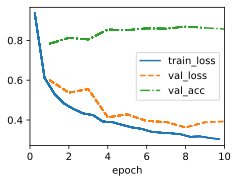

In [5]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

Let's [**have a look at the scale parameter `gamma`
and the shift parameter `beta`**] learned
from the first batch normalization layer.

让我们[**查看从第一个批量归一化层学习到的
缩放参数`gamma`和偏移参数`beta`**]。

In [6]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([2.0203, 1.5155, 1.8064, 2.0787, 1.9777, 1.3294], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-1.0251, -0.6625,  1.7383,  1.5161, -0.3890, -0.2076], device='cuda:0',
        grad_fn=<ViewBackward0>))

## [**Concise Implementation**]

Compared with the `BatchNorm` class,
which we just defined ourselves,
we can use the `BatchNorm` class defined in high-level APIs from the deep learning framework directly.
The code looks virtually identical
to our implementation above, except that we no longer need to provide additional arguments for it to get the dimensions right.

## [**简明实现**]

与我们刚刚自己定义的`BatchNorm`类相比，
我们可以直接使用深度学习框架高级API中定义的`BatchNorm`类。
该代码看起来与我们上面的代码几乎完全相同，
除了我们不再需要为其手动指定正确的维度参数。

In [7]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

Below, we [**use the same hyperparameters to train our model.**]
Note that as usual, the high-level API variant runs much faster
because its code has been compiled to C++ or CUDA
while our custom implementation must be interpreted by Python.

下面，我们[**使用相同的超参数来训练模型**]。
值得注意的是，与往常一样，高级API的实现运行速度更快，
因为其代码已编译为C++或CUDA，
而我们的自定义实现必须由Python解释执行。

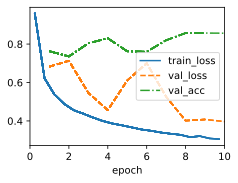

In [8]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Discussion

Intuitively, batch normalization is thought
to make the optimization landscape smoother.
However, we must be careful to distinguish between
speculative intuitions and true explanations
for the phenomena that we observe when training deep models.
Recall that we do not even know why simpler
deep neural networks (MLPs and conventional CNNs)
generalize well in the first place.
Even with dropout and weight decay,
they remain so flexible that their ability to generalize to unseen data
likely needs significantly more refined learning-theoretic generalization guarantees.

The original paper proposing batch normalization :cite:`Ioffe.Szegedy.2015`, in addition to introducing a powerful and useful tool,
offered an explanation for why it works:
by reducing *internal covariate shift*.
Presumably by *internal covariate shift* they
meant something like the intuition expressed above---the
notion that the distribution of variable values changes
over the course of training.
However, there were two problems with this explanation:
i) This drift is very different from *covariate shift*,
rendering the name a misnomer. If anything, it is closer to concept drift. 
ii) The explanation offers an under-specified intuition
but leaves the question of *why precisely this technique works*
an open question wanting for a rigorous explanation.
Throughout this book, we aim to convey the intuitions that practitioners
use to guide their development of deep neural networks.
However, we believe that it is important
to separate these guiding intuitions
from established scientific fact.
Eventually, when you master this material
and start writing your own research papers
you will want to be clear to delineate
between technical claims and hunches.

Following the success of batch normalization,
its explanation in terms of *internal covariate shift*
has repeatedly surfaced in debates in the technical literature
and broader discourse about how to present machine learning research.
In a memorable speech given while accepting a Test of Time Award
at the 2017 NeurIPS conference,
Ali Rahimi used *internal covariate shift*
as a focal point in an argument likening
the modern practice of deep learning to alchemy.
Subsequently, the example was revisited in detail
in a position paper outlining
troubling trends in machine learning :cite:`Lipton.Steinhardt.2018`.
Other authors
have proposed alternative explanations for the success of batch normalization,
some :cite:`Santurkar.Tsipras.Ilyas.ea.2018`
claiming that batch normalization's success comes despite exhibiting behavior
that is in some ways opposite to those claimed in the original paper.


We note that the *internal covariate shift*
is no more worthy of criticism than any of
thousands of similarly vague claims
made every year in the technical machine learning literature.
Likely, its resonance as a focal point of these debates
owes to its broad recognizability for the target audience.
Batch normalization has proven an indispensable method,
applied in nearly all deployed image classifiers,
earning the paper that introduced the technique
tens of thousands of citations. We conjecture, though, that the guiding principles
of regularization through noise injection, acceleration through rescaling and lastly preprocessing
may well lead to further inventions of layers and techniques in the future.

On a more practical note, there are a number of aspects worth remembering about batch normalization:

* During model training, batch normalization continuously adjusts the intermediate output of
  the network by utilizing the mean and standard deviation of the minibatch, so that the
  values of the intermediate output in each layer throughout the neural network are more stable.
* Batch normalization is slightly different for fully connected layers than for convolutional layers. In fact,
  for convolutional layers, layer normalization can sometimes be used as an alternative.
* Like a dropout layer, batch normalization layers have different behaviors
  in training mode than in prediction mode.
* Batch normalization is useful for regularization and improving convergence in optimization. By contrast,
  the original motivation of reducing internal covariate shift seems not to be a valid explanation.
* For more robust models that are less sensitive to input perturbations, consider removing batch normalization :cite:`wang2022removing`.

## Exercises

1. Should we remove the bias parameter from the fully connected layer or the convolutional layer before the batch normalization? Why?
1. Compare the learning rates for LeNet with and without batch normalization.
    1. Plot the increase in validation accuracy.
    1. How large can you make the learning rate before the optimization fails in both cases?
1. Do we need batch normalization in every layer? Experiment with it.
1. Implement a "lite" version of batch normalization that only removes the mean, or alternatively one that
   only removes the variance. How does it behave?
1. Fix the parameters `beta` and `gamma`. Observe and analyze the results.
1. Can you replace dropout by batch normalization? How does the behavior change?
1. Research ideas: think of other normalization transforms that you can apply:
    1. Can you apply the probability integral transform?
    1. Can you use a full-rank covariance estimate? Why should you probably not do that? 
    1. Can you use other compact matrix variants (block-diagonal, low-displacement rank, Monarch, etc.)?
    1. Does a sparsification compression act as a regularizer?
    1. Are there other projections (e.g., convex cone, symmetry group-specific transforms) that you can use?


## 讨论

直观上，批量归一化被认为可以使优化问题的解空间更加平滑。然而，我们必须谨慎区分推测性直觉与对深度模型训练现象的合理解释。回想一下，我们甚至不知道为什么简单的深度神经网络（多层感知机和传统卷积神经网络）首先就能很好地泛化。即使使用dropout和权重衰减，它们的灵活性仍然很高，因此其泛化到未见数据的能力可能需要更精细的学习理论保证。

提出批量归一化的原始论文 :cite:`Ioffe.Szegedy.2015`，除了引入这个强大而实用的工具外，还提供了解释其工作原理的理由：通过减少*内部协变量偏移*（internal covariate shift）。推测他们所说的*内部协变量偏移*类似于上述直观理解——即变量值的分布在训练过程中会发生变化。然而，这种解释存在两个问题：
i) 这种偏移与*协变量偏移*非常不同，导致名称存在用词不当。更准确地说，它更接近于概念漂移（concept drift）。
ii) 这种解释提供的是未充分说明的直觉，但将*为何该技术有效*的问题留待更严谨的解释。

批量归一化成功后，关于*内部协变量偏移*的解释在技术文献和机器学习研究的广泛讨论中反复出现。在2017年NeurIPS会议上获得时间检验奖的演讲中，Ali Rahimi以*内部协变量偏移*为焦点，将深度学习的现代实践比作炼金术。随后，在一篇立场论文中详细回顾了这个例子 :cite:`Lipton.Steinhardt.2018`。其他作者提出了批量归一化成功的替代解释，其中一些 :cite:`Santurkar.Tsipras.Ilyas.ea.2018` 声称批量归一化的成功尽管其行为在某些方面与原始论文的主张相反。

从实践的角度看，关于批量归一化有几个值得注意的方面：

* 在模型训练期间，批量归一化通过利用小批量的均值和标准差，持续调整网络的中间输出，使得整个神经网络各层的中间输出值更加稳定。
* 批量归一化在全连接层和卷积层的实现略有不同。事实上，对于卷积层，有时可以使用层归一化作为替代方案。
* 与dropout层类似，批量归一化层在训练模式和预测模式下的行为不同。
* 批量归一化有助于正则化和提高优化过程的收敛性。相比之下，减少内部协变量偏移的原始动机似乎并不是一个有效的解释。
* 对于需要更鲁棒、对输入扰动不敏感的模型，可考虑移除批量归一化 :cite:`wang2022removing`。

## 练习

1. 是否应该在批量归一化之前移除全连接层或卷积层的偏置参数？为什么？
1. 比较有批量归一化和无批量归一化时LeNet的学习率。
    1. 绘制验证准确率的变化曲线。
    1. 在两种情况下，优化失败前的最大学习率是多少？
1. 是否需要在每个层中使用批量归一化？通过实验验证。
1. 实现仅去除均值的"简化版"批量归一化，或仅去除方差的版本。观察其行为。
1. 固定参数`beta`和`gamma`。观察并分析结果。
1. 能否用批量归一化替代dropout？行为会发生什么变化？
1. 研究思路：思考可以应用的其他归一化变换：
    1. 能否应用概率积分变换？
    1. 能否使用满秩协方差估计？为什么这可能不可行？
    1. 能否使用其他紧凑矩阵变体（块对角、低位移秩、Monarch矩阵等）？
    1. 稀疏化压缩是否起到正则化作用？
    1. 是否存在其他投影变换（如凸锥、对称群特定变换）可以使用？

[Discussions](https://discuss.d2l.ai/t/84)
